In [1]:
import ast
import os
import re
from datetime import datetime as dt

import icecream
import jax.numpy as jnp
import numpy as np
import pandas as pd
from flax import nnx
from icecream import ic

# from torch.utils.tensorboard import SummaryWriter
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
from transformers import BertTokenizerFast, FlaxBertModel

import hephaestus as hp
import hephaestus.training as ht

icecream.install()
ic_disable = True  # Global variable to disable ic
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)
pd.options.mode.copy_on_write = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
model = FlaxBertModel.from_pretrained(model_name)
tokenizer = BertTokenizerFast.from_pretrained(model_name)

# Get the embeddings matrix
embeddings = model.params["embeddings"]["word_embeddings"]["embedding"]

# Now you can access specific embeddings like this:
# For example, to get embeddings for tokens 23, 293, and 993:
selected_embeddings = jnp.take(embeddings, jnp.array([23, 293, 993]), axis=0)

# If you want to get embeddings for specific words:
words = ["hello", "world", "example"]
tokens = tokenizer.convert_tokens_to_ids(words)
word_embeddings = jnp.take(embeddings, jnp.array(tokens), axis=0)
word_embeddings.shape

Some weights of FlaxBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: {('pooler', 'dense', 'kernel'), ('pooler', 'dense', 'bias')}
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(3, 768)

In [3]:
def line2df(line, idx):
    data_rows = []
    line = ast.literal_eval(line)
    for i, time_step in enumerate(line["data"]):
        row = {"time_step": i}
        # Add position data for each planet
        for j, position in enumerate(time_step):
            row[f"planet{j}_x"] = position[0]
            row[f"planet{j}_y"] = position[1]
        data_rows.append(row)

    df = pd.DataFrame(data_rows)
    description = line.pop("description")
    step_size = description.pop("stepsize")
    for k, v in description.items():
        for k_prop, v_prop in v.items():
            df[f"{k}_{k_prop}"] = v_prop
    df["time_step"] = df["time_step"] * step_size
    df.insert(0, "idx", idx)

    return df

In [4]:
files = os.listdir("data")
if "planets.parquet" not in files:
    with open("data/planets.data") as f:
        data = f.read().splitlines()

        dfs = []
        for idx, line in enumerate(tqdm(data)):
            dfs.append(line2df(line, idx))
        df = pd.concat(dfs)
    df.to_parquet("data/planets.parquet")
else:
    df = pd.read_parquet("data/planets.parquet")


# Combine total mass of all planets into one column `planet<n>_m`
mass_regex = re.compile(r"planet(\d+)_m")
mass_cols = [col for col in df.columns if mass_regex.match(col)]
df["total_mass"] = df[mass_cols].sum(axis=1)
# df = df.reset_index(drop=True)
# Introduce categorical columns for the number of planets choose non null columns with mass
df["n_planets"] = df[mass_cols].notnull().sum(axis=1).astype("object")
df["n_planets"] = df["n_planets"].apply(lambda x: f"{x}_planets")
# Create category acceleration if the sum of plane/d_[x,y, z] is greater than 0
df["acceleration_x"] = df[
    [col for col in df.columns if "planet" in col and "_x" in col]
].sum(axis=1)
# Set acceleration_x to "increasing" if greater than 0 else "decreasing"
df["acceleration_x"] = (
    df["acceleration_x"]
    .apply(lambda x: "increasing" if x > 0 else "decreasing")
    .astype("object")
)
df["acceleration_y"] = df[
    [col for col in df.columns if "planet" in col and "_y" in col]
].sum(axis=1)
df["acceleration_y"] = df["acceleration_y"].apply(
    lambda x: "increasing" if x > 0 else "decreasing"
)


df.describe()

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass
count,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,4.165044e+06,4.165044e+06,5.563957e+06,5.563957e+06,...,2.783627e+06,2.783627e+06,2.783627e+06,2.783627e+06,1.392864e+06,1.392864e+06,1.392864e+06,1.392864e+06,1.392864e+06,5.563957e+06
mean,6.248635e+04,9.748911e+00,-1.339198e-01,7.391138e-02,-1.340140e-01,7.291389e-02,-1.305344e-01,7.065633e-02,2.999306e+00,1.624756e+00,...,6.559150e-02,2.996303e+00,1.623874e+00,9.980576e-01,-1.276881e-01,6.519469e-02,3.002531e+00,1.625815e+00,1.001317e+00,1.049149e+01
std,3.607949e+04,5.993534e+00,1.228071e+00,1.213232e+00,1.227950e+00,1.212650e+00,1.217229e+00,1.203678e+00,1.157182e+00,5.876632e-01,...,1.200148e+00,1.153190e+00,5.270725e-01,5.764675e-01,1.211648e+00,1.199625e+00,1.156856e+00,5.167198e-01,5.779763e-01,3.991780e+00
min,0.000000e+00,0.000000e+00,-3.294763e+00,-2.997514e+00,-3.284004e+00,-2.998546e+00,-3.289790e+00,-2.998050e+00,1.000003e+00,1.000000e+00,...,-2.997621e+00,1.000054e+00,1.000000e+00,9.369537e-05,-3.273603e+00,-2.998913e+00,1.000103e+00,1.000000e+00,6.720938e-05,2.014597e+00
25%,3.124400e+04,4.655172e+00,-1.030131e+00,-9.020907e-01,-1.030516e+00,-9.028009e-01,-1.050662e+00,-9.211662e-01,1.993948e+00,1.000000e+00,...,-9.321272e-01,1.996853e+00,1.191548e+00,4.980967e-01,-1.071974e+00,-9.394428e-01,2.004240e+00,1.215927e+00,5.032645e-01,7.282371e+00
50%,6.249100e+04,9.523810e+00,-1.542335e-01,1.117099e-01,-1.538916e-01,1.099474e-01,-1.525520e-01,1.118031e-01,2.994477e+00,1.543047e+00,...,1.067355e-01,3.001879e+00,1.535683e+00,9.955040e-01,-1.507184e-01,1.055276e-01,3.000454e+00,1.519040e+00,1.003118e+00,1.028205e+01
75%,9.372800e+04,1.440000e+01,8.583344e-01,9.784987e-01,8.581045e-01,9.783998e-01,8.762358e-01,9.912902e-01,4.005747e+00,2.020672e+00,...,9.956064e-01,3.986406e+00,1.969644e+00,1.497746e+00,8.906780e-01,9.991220e-01,4.003332e+00,1.950518e+00,1.503457e+00,1.345633e+01
max,1.249990e+05,2.400000e+01,2.996370e+00,2.999014e+00,2.993319e+00,2.999536e+00,2.990464e+00,2.998478e+00,4.999994e+00,2.999984e+00,...,3.000881e+00,4.999990e+00,2.999909e+00,1.999957e+00,2.985180e+00,2.998936e+00,4.999679e+00,2.999497e+00,1.999999e+00,2.382455e+01


In [5]:
df.head()

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass,n_planets,acceleration_x,acceleration_y
0,0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
1,0,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
2,0,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
3,0,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
4,0,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing


In [6]:
df_categorical = df.select_dtypes(include=["object"]).astype(str)
unique_values_per_column = df_categorical.apply(
    pd.Series.unique
).values  # .flatten().tolist()
flattened_unique_values = np.concatenate(unique_values_per_column).tolist()
unique_values = list(set(flattened_unique_values))
unique_values

['4_planets',
 'decreasing',
 '3_planets',
 'increasing',
 '2_planets',
 '5_planets']

In [7]:
df.select_dtypes(include="object").groupby(
    df.select_dtypes(include="object").columns.tolist()
).size().reset_index(name="count")

,n_planets,acceleration_x,acceleration_y,count
0,2_planets,decreasing,decreasing,365720
1,2_planets,decreasing,increasing,410992
2,2_planets,increasing,decreasing,272240
3,2_planets,increasing,increasing,349961
4,3_planets,decreasing,decreasing,410092
5,3_planets,decreasing,increasing,404513
6,3_planets,increasing,decreasing,258536
7,3_planets,increasing,increasing,308276
8,4_planets,decreasing,decreasing,413451
9,4_planets,decreasing,increasing,416444


In [8]:
df = df.reset_index(drop=True)

In [9]:
# Get train test split at 80/20
time_series_config = hp.TimeSeriesConfig.generate(df=df)
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
# del df
train_ds = hp.TimeSeriesDS(train_df, time_series_config)
test_ds = hp.TimeSeriesDS(test_df, time_series_config)
len(train_ds), len(test_ds)

(99999, 25001)

In [10]:
def make_batch(ds: hp.TimeSeriesDS, start: int, length: int):
    numeric = []
    categorical = []
    for i in range(start, length + start):
        numeric.append(ds[i][0])
        categorical.append(ds[i][1])
    # print index of None values
    return {"numeric": jnp.array(numeric), "categorical": jnp.array(categorical)}


batch = make_batch(train_ds, 0, 4)
print(batch["numeric"].shape, batch["categorical"].shape)

# (4, 27, 59) (4, 3, 59)
# batch

(4, 27, 59) (4, 3, 59)


In [ ]:
multiplier = 4
tabular_decoder = hp.TimeSeriesDecoder(
    time_series_config, d_model=1024, n_heads=8 * multiplier, rngs=nnx.Rngs(0)
)
# nnx.display(tabular_decoder)

In [ ]:
res = tabular_decoder(
    numeric_inputs=batch["numeric"],
    categorical_inputs=batch["categorical"],
    deterministic=False,
)

In [13]:
res["numeric_out"].shape, res["categorical_out"].shape

((4, 27, 59), (4, 3, 59, 41))

In [14]:
if jnp.isnan(res["numeric_out"]).any():
    raise ValueError("NaN in numeric_out")
if jnp.isnan(res["categorical_out"]).any():
    raise ValueError("NaN in categorical_out")

In [15]:
ic.disable()

In [ ]:
metric_history = ht.create_metric_history()

learning_rate = 4e-3
momentum = 0.9
optimizer = ht.create_optimizer(tabular_decoder, learning_rate, momentum)

metrics = ht.create_metrics()
writer_name = "LowerRate"
# Get git commit hash for model name?
writer_time = dt.now().strftime("%Y-%m-%dT%H:%M:%S")
commit_hash = hp.get_git_commit_hash()
model_name = f"{writer_time}_{writer_name}_{commit_hash}"
summary_writer = SummaryWriter("runs/" + model_name)


train_data_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
train_step = ht.create_train_step(
    model=tabular_decoder, optimizer=optimizer, metrics=metrics
)
early_stop = 10
for step, batch in enumerate(tqdm(train_data_loader)):
    if early_stop and step > early_stop:
        break
    batch = {"numeric": jnp.array(batch[0]), "categorical": jnp.array(batch[1])}
    train_step(tabular_decoder, batch, optimizer, metrics)
    for metric, value in metrics.compute().items():
        # Only shows `loss`

        metric_history[metric].append(value)
        if jnp.isnan(value).any():
            raise ValueError("Nan Values")
        summary_writer.add_scalar(f"train/{metric}", np.array(value), step)

    metrics.reset()

  0%|          | 0/6250 [00:00<?, ?it/s]

In [ ]:
df_comp = hp.show_results_df(
    model=tabular_decoder,
    time_series_config=time_series_config,
    dataset=train_ds,
    idx=0,
)

In [18]:
df_comp.output_df.loc[:, time_series_config.categorical_col_tokens].head()

,n_planets,acceleration_x,acceleration_y
0,25,32,6
1,22,25,17
2,22,32,17
3,3,25,6
4,3,25,22


In [19]:
df_comp.output_df.loc[:, time_series_config.numeric_col_tokens].head()

,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,planet0_e,...,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass
0,-0.229161,-0.320024,0.160963,-0.060539,-0.003132,-0.801562,-0.169972,1.108958,0.468987,-0.010044,...,-0.697796,-0.356687,0.830590,-0.120877,0.075109,0.514436,-0.121058,0.845175,-0.731823,0.084641
1,0.033292,-0.057526,0.438864,-0.258350,-0.664500,-0.111452,-0.304117,1.616580,0.508615,0.368903,...,-0.392449,-0.120686,0.500312,0.217941,-0.310838,0.164819,0.020052,0.322412,-0.695755,-0.062031
2,0.336307,-0.285842,0.437482,0.018081,-0.938158,-0.633720,-0.417733,1.561024,1.079381,0.504280,...,0.290784,0.035139,0.928963,0.241352,-0.280169,0.108599,-0.216858,0.836886,-0.598973,-0.126241
3,0.190398,-0.445634,0.420552,-0.471713,-0.607119,-0.452770,-0.610094,1.116345,0.343207,0.311351,...,-0.368036,-0.012814,0.821000,0.638144,-0.065258,0.260506,-0.637764,0.390538,-1.322428,0.126919
4,-0.236750,0.227104,0.151679,0.183239,-0.631930,-0.673837,-0.718302,1.415682,0.757779,0.142008,...,-0.491293,0.117810,0.552759,0.581225,-0.008237,-0.014103,-0.399807,0.076229,-0.939349,-0.020356


In [ ]:
test_inputs = hp.AutoRegressiveResults.from_ds(train_ds, 0, 13)

# inputs_test = train_ds[0]
# test_numeric = inputs_test[0]
# test_categorical = inputs_test[1]
# print(inputs_test.shape)
for i in trange(21):
    test_inputs = hp.auto_regressive_predictions(tabular_decoder, test_inputs)

# x = auto_regressive_predictions(state, test_ds[0], 10)

  0%|          | 0/21 [00:00<?, ?it/s]

In [21]:
auto_df = hp.create_test_inputs_df(test_inputs, time_series_config)

In [22]:
auto_df.head(20)

,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,planet0_e,...,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass,n_planets,acceleration_x,acceleration_y
0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,34.0,35.0,35.0
1,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,34.0,35.0,35.0
2,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,34.0,35.0,35.0
3,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,34.0,35.0,35.0
4,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,34.0,35.0,35.0
5,2.325581,1.533811,0.905607,-1.000151,0.053178,-0.405638,2.868949,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,34.0,35.0,35.0
6,2.790698,1.335526,1.206832,-0.918192,-0.399688,-0.674529,2.825381,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,34.0,33.0,35.0
7,3.255814,1.087824,1.463513,-0.641980,-0.767958,-0.937474,2.756889,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,34.0,33.0,35.0
8,3.720930,0.801365,1.668203,-0.229808,-0.973515,-1.192211,2.664256,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,34.0,33.0,35.0
9,4.186047,0.487549,1.816168,0.231092,-0.972449,-1.436585,2.548458,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,34.0,33.0,35.0


In [ ]:
res1 = tabular_decoder(
    numeric_inputs=jnp.array([train_ds[0][0][:, :10]]),
    categorical_inputs=jnp.array([train_ds[0][1][:, :10]]),
)


res_df = hp.create_non_auto_df(res1, time_series_config)
actual_df = hp.create_non_auto_df(
    {"numeric_out": train_ds[0][0], "categorical_out": train_ds[0][1]},
    time_series_config,
)

In [24]:
hp.create_non_auto_df(
    {"numeric_out": train_ds[0][0], "categorical_out": train_ds[0][1]},
    time_series_config,
)

,n_planets,acceleration_x,acceleration_y,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,...,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass
0,34.0,35.0,35.0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
1,34.0,35.0,35.0,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
2,34.0,35.0,35.0,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
3,34.0,35.0,35.0,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
4,34.0,35.0,35.0,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
5,34.0,35.0,35.0,2.325581,1.533811,0.905607,-1.000151,0.053178,-0.405638,2.868949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
6,34.0,33.0,35.0,2.790698,1.335526,1.206832,-0.918192,-0.399688,-0.674529,2.825381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
7,34.0,33.0,35.0,3.255814,1.087824,1.463513,-0.641980,-0.767958,-0.937474,2.756889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
8,34.0,33.0,35.0,3.720930,0.801365,1.668203,-0.229808,-0.973515,-1.192211,2.664256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
9,34.0,33.0,35.0,4.186047,0.487549,1.816168,0.231092,-0.972449,-1.436585,2.548458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123


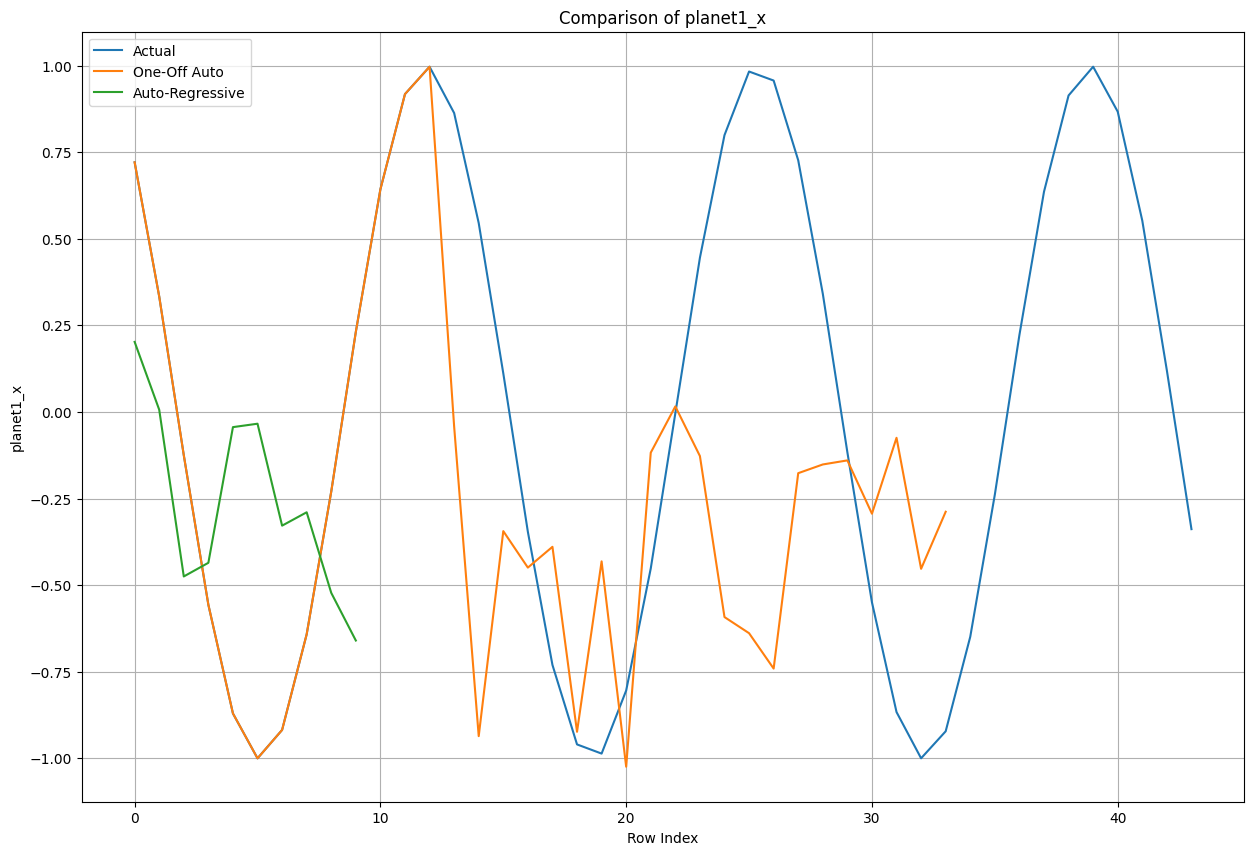

In [25]:
hp.plot_comparison(actual_df, auto_df, res_df, "planet1_x")